# 04. PyTorch Custom Datasets Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this code
torch.__version__

'2.0.1+cpu'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


## 1. Get data

Our dataset is a subset of Food101 dataset.

Food101 starts 101 different classe of food and 1000 images per class (750 training and 250 testing)

Our dataset starts with 3 classes of food and only 10% os the images (~75 training, 25 testing).

Why do this?

While staritng out ML projects, its important to try things on a small scale and then increase the scale when necessary.

The whole point is to speedup how you can experiment

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


## 2. Becoming one with the data (data preperation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    """ Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test" 

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Pythons random.choice()
3. Get the image class name using 'pathlib.Path.parent.stem'
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


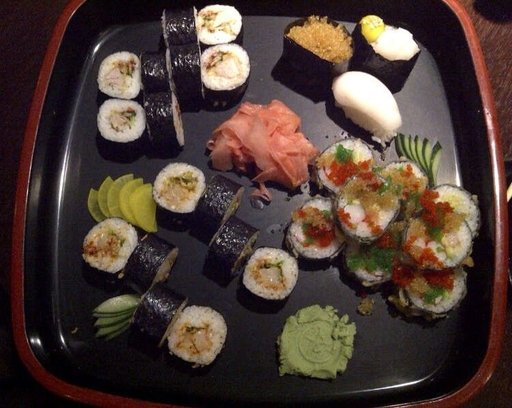

In [8]:
import random
from PIL import Image

#Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

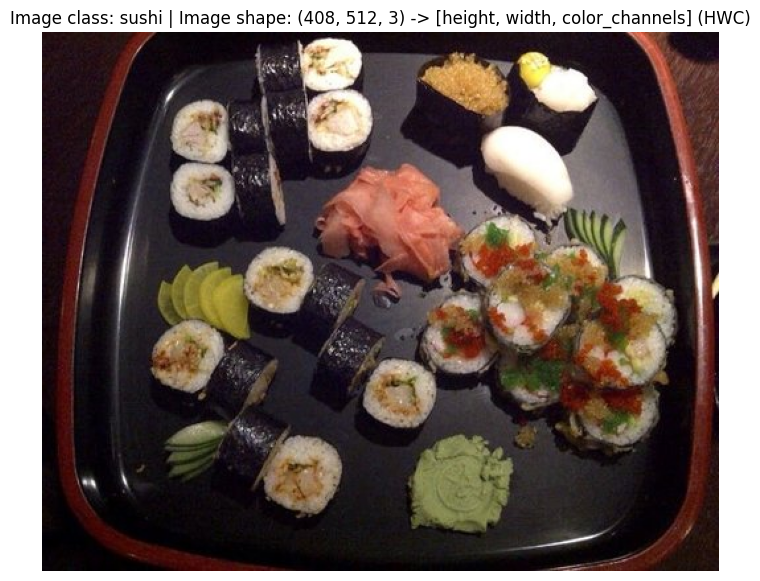

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.array(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors(in our case, numerical representation of our images).
2. Turn it into a 'torch.utils.data.Dataset' and subsequently a 'torch.untils.data.DataLoader', we'll call these 'Dataset' and 'DataLoader'.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transdforming data with 'torchvision.transforms'

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [11]:
#Write a transform for image
data_transform = transforms.Compose([
    #Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.0824, 0.0824, 0.0863,  ..., 0.1412, 0.1373, 0.1294],
         [0.0902, 0.0902, 0.0902,  ..., 0.1412, 0.1373, 0.1255],
         [0.1137, 0.0980, 0.1059,  ..., 0.1333, 0.1412, 0.1294],
         ...,
         [0.1412, 0.1373, 0.1294,  ..., 0.0157, 0.0196, 0.0157],
         [0.1333, 0.1373, 0.1255,  ..., 0.0275, 0.0275, 0.0275],
         [0.1255, 0.1294, 0.1137,  ..., 0.0275, 0.0314, 0.0314]],

        [[0.0431, 0.0431, 0.0392,  ..., 0.0667, 0.0588, 0.0588],
         [0.0353, 0.0431, 0.0392,  ..., 0.0667, 0.0549, 0.0588],
         [0.0392, 0.0471, 0.0471,  ..., 0.0627, 0.0627, 0.0510],
         ...,
         [0.0667, 0.0667, 0.0667,  ..., 0.0078, 0.0078, 0.0039],
         [0.0667, 0.0706, 0.0706,  ..., 0.0118, 0.0118, 0.0118],
         [0.0667, 0.0667, 0.0667,  ..., 0.0196, 0.0157, 0.0118]],

        [[0.0745, 0.0706, 0.0706,  ..., 0.0667, 0.0667, 0.0667],
         [0.0863, 0.0902, 0.0941,  ..., 0.0863, 0.0784, 0.0784],
         [0.1137, 0.1059, 0.0941,  ..., 0.0941, 0.0863, 0.

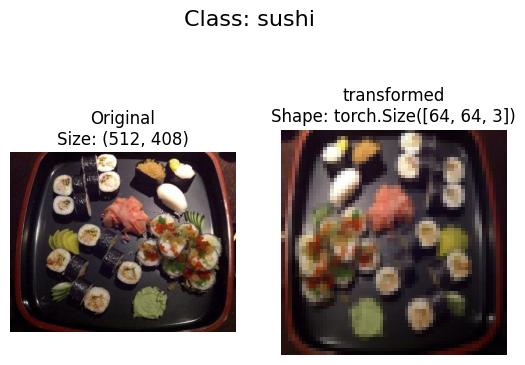

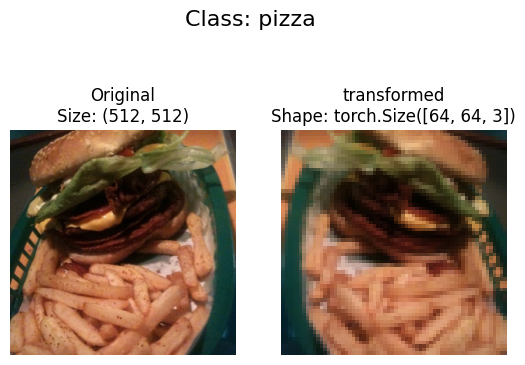

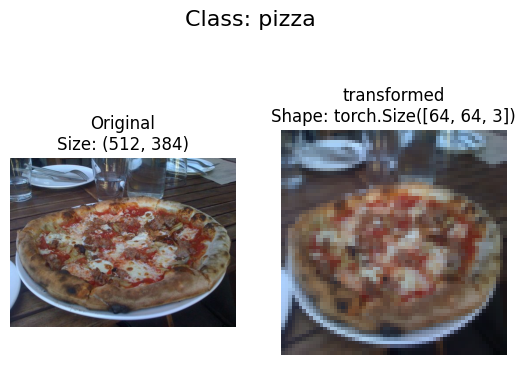

In [13]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths =  random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            #Transform and plot target image
            transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, seed=42)    

## 4. Option 1: Loading image data using 'ImageFolder'

We can load image classification using 'torchvision.datasets.ImageFolder' - https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder 

In [14]:
#Use image folder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform, # a transfrom for the data
                                  target_transform=None) # atransform for the label
test_data = datasets.ImageFolder(root = test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get classnmes as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and labe
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"mage Datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

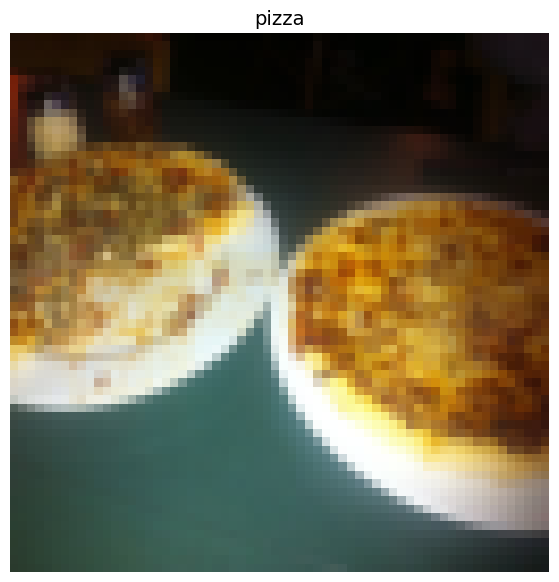

In [20]:
# Rearrange the order of dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

#Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

## 4.1 Turn loaded images into 'DataLoaders"

A 'DataLoader' is going to help us turn our 'Dataset' into iterables and we can customize the 'batch_size' so our model can see 'batch_size' images at a time.

In [21]:
import os
os.cpu_count()

4

In [25]:
# Turn train and test datasets into dataloaders
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers= 1, shuffle= True)
test_dataloader = DataLoader(dataset=test_data, batch_size= BATCH_SIZE, num_workers= 1, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x212b8bd7910>,
 <torch.utils.data.dataloader.DataLoader at 0x212ca7aff10>)

In [26]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [27]:
img, label = next(iter(train_dataloader))

# Change batchsize if needed
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
